# ExtraTrees model for Bike sharing dataset

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesRegressor

import graphviz

import warnings
import pickle

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 15, 7

warnings.filterwarnings("ignore")

## 1. Data import

In [3]:
DATADIR = '../data/bike/'
MODELDIR = '../checkpoints/bike-sharing/et/'

data_path = os.path.join(DATADIR, 'bike-sharing-processed.csv')
data = pd.read_csv(data_path)

In [4]:
data.set_index('date', inplace=True)
data.sort_index(inplace=True)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
date,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


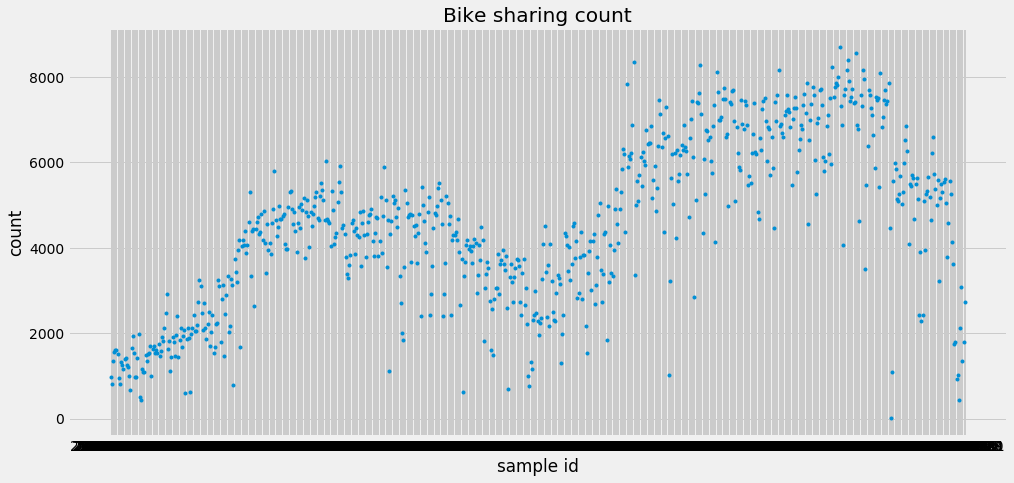

In [5]:
plt.plot(data.cnt, '.')
plt.title('Bike sharing count')
plt.xlabel('sample id')
plt.ylabel('count')
plt.show()

## 2. Train test split

In [6]:
y = data[['cnt']].copy()
X = data.drop(columns=['cnt'], axis=1)

print(f'X and y shape:')
print(X.shape, y.shape)

X and y shape:
(731, 12) (731, 1)


In [7]:
# date selection
datelist = data.index.unique()

# two month data for testset
print(f'Test start date: {datelist[-61]}')

Test start date: 2012-11-01


In [8]:
# Train test split : last 60 days for test set

X_train = X[X.index < datelist[-61]]
X_test = X[X.index >= datelist[-61]]

y_train = y[y.index < datelist[-61]]
y_test = y[y.index >= datelist[-61]]

print(f'Size of train and test set respectively:')
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

Size of train and test set respectively:
(670, 12) (61, 12) (670, 1) (61, 1)


## 3. Parameter selection using grid search

In [9]:
grid_param = {
    'max_depth': [3, 5, 7],
    'max_features': [0.7, 1.0],
    'n_estimators' : [200, 300],
    'min_samples_leaf': [3, 5, 7]
}

et = ExtraTreesRegressor()
et = GridSearchCV(estimator=et, param_grid=grid_param)
et.fit(X_train, y_train)

print(f'Best Paramters: {et.best_params_}')

Best Paramters: {'max_depth': 7, 'max_features': 0.7, 'min_samples_leaf': 3, 'n_estimators': 300}


In [10]:
# final parameters
params = {
    'max_depth': 7,
    'max_features': 0.7,
    'n_estimators' : 300,
    'min_samples_leaf': 3
}

In [11]:
model = ExtraTreesRegressor(**params)
model.fit(X_train, y_train)

# save model weights and 
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

pickle.dump(model, open(os.path.join(MODELDIR, 'et.model'), 'wb'))

In [12]:
def model_evaluation(X_train, X_test, y_train, y_test):
    
    # predict and tranform to original scale
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # MAE and NRMSE calculation
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_nrmse = train_rmse/np.std(y_train.values)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_nrmse = test_rmse/np.std(y_test.values)

    print(f'Training MAE: {np.round(train_mae, 3)}')
    print(f'Trainig NRMSE: {np.round(train_nrmse, 3)}')
    print()

    print(f'Test MAE: {np.round(test_mae)}')
    print(f'Test NRMSE: {np.round(test_nrmse)}')
    
    return y_train_pred, y_test_pred

In [13]:
y_train_pred, y_test_pred = model_evaluation(X_train, X_test, y_train, y_test)

Training MAE: 365.08
Trainig NRMSE: 0.258

Test MAE: 929.0
Test NRMSE: 1.0


## 6. Result plotting

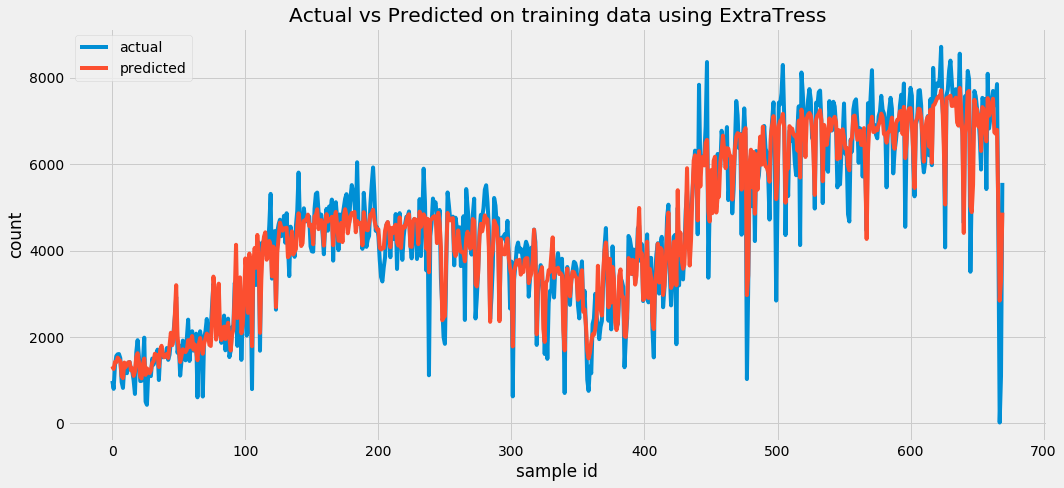

In [14]:
plt.plot(y_train.values, label='actual')
plt.plot(y_train_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on training data using ExtraTress')
plt.legend()
plt.tight_layout()
plt.show()

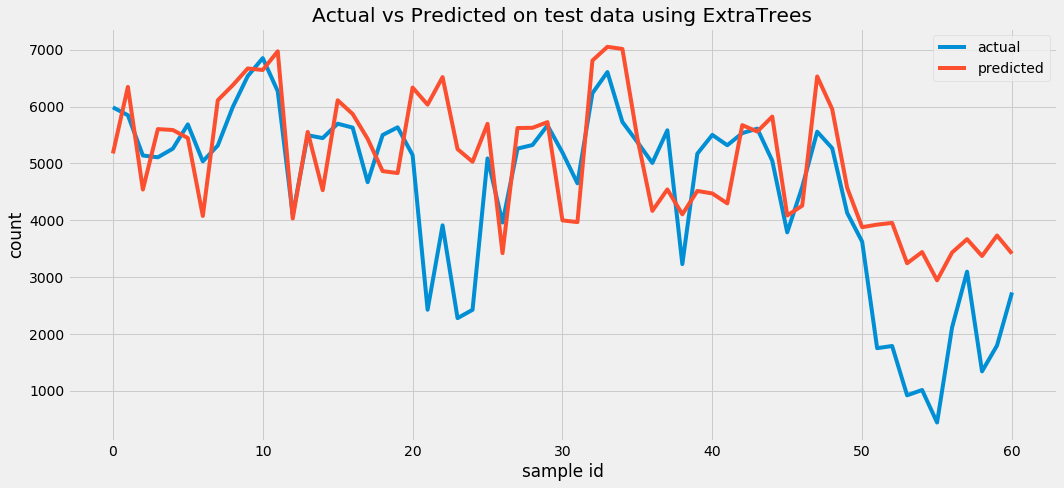

In [15]:
plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using ExtraTrees')
plt.legend()
plt.tight_layout()
plt.show()